In [1]:
USER = 'Paolo'
MONK_TASK = 2

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    sys.path.insert(0,BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0,BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras

    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk', f'monks-{MONK_TASK}.test')

    IMAGES_DIR = os.path.join(BASE_PATH, 'images', 'monk', f'task-{MONK_TASK}')
    RF_IMAGES_DIR = os.path.join(IMAGES_DIR, 'random_forest')
    SVM_IMAGES_DIR = os.path.join(IMAGES_DIR, 'SVM')
    NN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'neural_network')

    MODELS_DIR = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
    RF_MODEL = os.path.join(MODELS_DIR, 'random_forest_model.joblib')
    SVM_MODEL = os.path.join(MODELS_DIR, 'SVM_model.joblib')
    NN_MODEL = os.path.join(MODELS_DIR, 'NN_model.joblib')
else :
    N_JOBS = -1

    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')

    IMAGES_DIR = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}')
    RF_IMAGES_DIR = os.path.join(IMAGES_DIR, 'random_forest')
    SVM_IMAGES_DIR = os.path.join(IMAGES_DIR, 'SVM')
    NN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'neural_network')

    MODELS_DIR = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')
    RF_MODEL = os.path.join(MODELS_DIR, 'random_forest_model.joblib')
    SVM_MODEL = os.path.join(MODELS_DIR, 'SVM_model.joblib')
    NN_MODEL = os.path.join(MODELS_DIR, 'NN_model.joblib')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from sklearn.metrics import confusion_matrix, roc_curve, auc

from utils import save_plot

In [4]:
from joblib import load

rf = load(RF_MODEL)
svm = load(SVM_MODEL)
nn = load(NN_MODEL)

In [5]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')

features = ['feature_' + str(i) for i in range(1, 7)]
new_column_names = ['class'] + features

df_test.columns = new_column_names
df_test.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [6]:
df_test_encoded = pd.get_dummies(df_test, columns=features)
df_test_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
2,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
3,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
4,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0


In [7]:
features = df_test_encoded.columns.difference(['class'])

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

In [8]:
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_nn = nn.predict(X_test)

14/14 [==============================] - 0s 1ms/step


# Confusion matrices

In [9]:
def confusion_matrix_heatmap(y_true, y_scores, model_images_dir=None):
    if model_images_dir == RF_IMAGES_DIR:
        model_name = 'Random Forest'
    elif model_images_dir == SVM_IMAGES_DIR:
        model_name = 'SVM'
    elif model_images_dir == NN_IMAGES_DIR:
        model_name = 'Neural Network'
    else:
        raise ValueError('model_images_dir must not be None')

    cf_matrix = confusion_matrix(y_true, y_scores)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{count}\n{name}\n({percentage})'
              for name, count, percentage in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno_r', cbar=False, annot_kws={'size': 10})

    plt.title(f'{model_name} Confusion Matrix', fontweight='bold')
    plt.xlabel('Predicted Class', fontweight='bold')
    plt.ylabel('True Class', fontweight='bold')
    save_plot(plt, model_images_dir, 'confusion_matrix')
    plt.show()

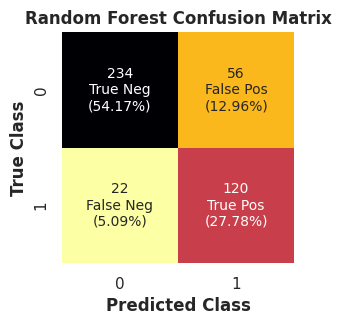

In [10]:
confusion_matrix_heatmap(y_test, y_pred_rf, model_images_dir=RF_IMAGES_DIR)

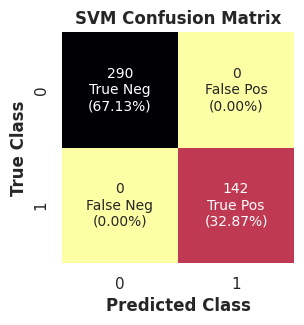

In [11]:
confusion_matrix_heatmap(y_test, y_pred_svm, model_images_dir=SVM_IMAGES_DIR)

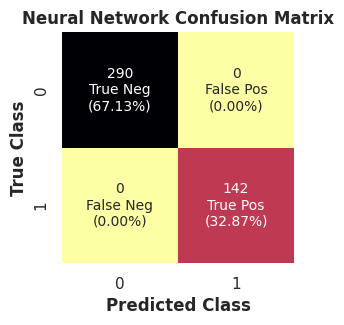

In [12]:
confusion_matrix_heatmap(y_test, y_pred_nn, model_images_dir=NN_IMAGES_DIR)

# ROC curves

In [13]:
def plot_roc_curve(y_true, y_scores, model_images_dir=None):
    if model_images_dir == RF_IMAGES_DIR:
        model_name = 'Random Forest'
    elif model_images_dir == SVM_IMAGES_DIR:
        model_name = 'SVM'
    elif model_images_dir == NN_IMAGES_DIR:
        model_name = 'Neural Network'
    else:
        raise ValueError('model_images_dir must not be None')

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title(f'{model_name} ROC Curve', fontweight='bold')
    plt.legend(loc='lower right')
    save_plot(plt, model_images_dir, 'ROC Curve')
    plt.show()

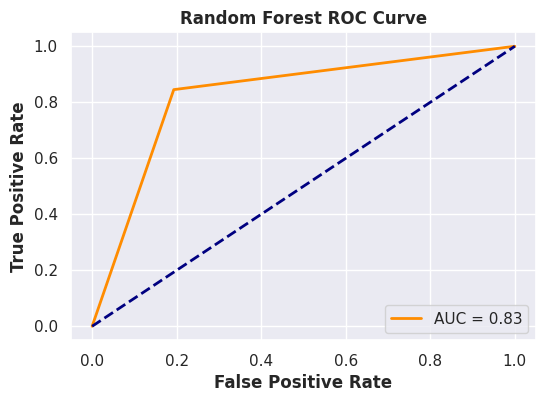

In [14]:
plot_roc_curve(y_test, y_pred_rf, model_images_dir=RF_IMAGES_DIR)

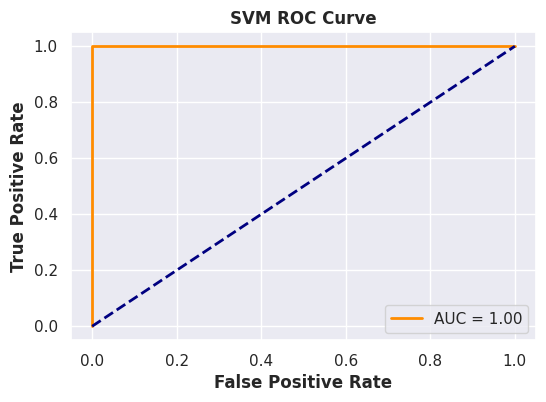

In [15]:
plot_roc_curve(y_test, y_pred_svm, model_images_dir=SVM_IMAGES_DIR)

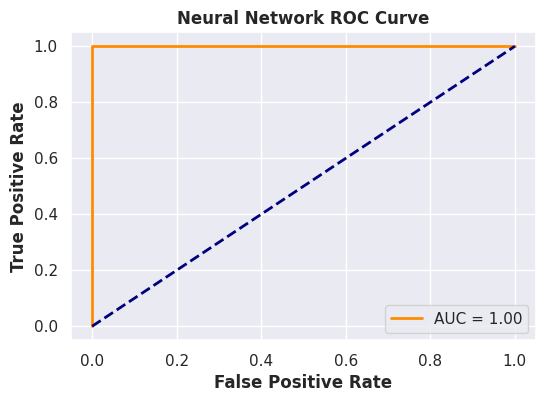

In [16]:
plot_roc_curve(y_test, y_pred_nn, model_images_dir=NN_IMAGES_DIR)